In [1]:
#https://ckc.tir.tw/index.php/s/KEtbw63dbD4yjmn#pdfviewer
#How to Measure the Information Gained From One Symbol

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [28]:
# exp_folder = 'D:\\Leo\\0503'
# exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0503'
exp_folder = 'D:\\Leo\\0503'

annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G4.5_5min_Q100_6.5mW_1Hz_re.mat')
# annots2 = loadmat(exp_folder+'\\Analyzed_data\\30Hz_27_RF\\unsort\\RF_properties.mat')
# RGCcenter = annots2['RF_properties']

In [4]:
channelnumber =52
deltaT =0.7
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [5]:
#import and define functions
from PIfunc import PIfunc
from EqualState import EqualState
def Fake_Spike_Activation_function(realr, r, distribution, noise_list):
    rstate=np.zeros(len(r))
    model = 0
    if distribution == 'burst distributed':
        model += 10
    elif distribution == 'real distributed':
        model += 20
    elif distribution == 'fake distributed':
        model += 30
    for noise in noise_list:
        if noise == 'poisson process':
            model += 1
        elif noise == 'randomly not fire':
            model += 100
    model
    if model == 121: #'randomly not fire' + 'real distributed' + 'poisson process'
        counter = 0
        for n in np.arange(1, max(realr)+1):
            edge = np.sort(r)[counter]
            counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
            rstate[r>=edge] = np.random.poisson(n)
        randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    elif model == 21: #'real distributed' + 'poisson process'
        counter = 0
        for n in np.unique(realr):
            edge = np.sort(r)[counter]
            counter += (np.shape(np.where(realr==n))[1])
            rstate[r>=edge] = np.random.poisson(n)
    elif model == 30: #'fake distributed' 
        edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
        rstate=np.zeros(len(r))
        for i in range(4):
            rstate[r>=edges[i]] = i
    elif model == 110: #'randomly not fire' + 'burst distributed' + 'randomly not fire' 
        counter = 0
        burst_distr = np.array([0.95, 0.03, 0.02]);
        for n in np.arange(1,3):
            edge = np.sort(r)[int(counter)]
            counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
            rstate[r>=edge] = n
        randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    else:  #'real spike'
        rstate = np.nan
    return rstate

(150, 160)

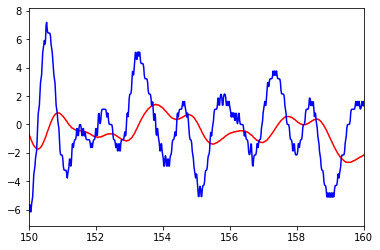

In [6]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'b-')
plt.xlim(150,160)

In [7]:
realr, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
N, edges = np.histogram(realr, [0,1,2,100])
N/sum(N)

array([0.9668407 , 0.03010442, 0.00305488])

In [8]:
r = x+v*deltaT
rstate=np.zeros(len(r))
realr[realr >= 1]= 1
rstate = realr
# rstate = Fake_Spike_Activation_function(realr, r, 'burst distributed', ['randomly not fire'])
# rstate = Fake_Spike_Activation_function(realr, r, 'fake distributed', [])

In [9]:
#rstate = np.random.poisson(rstate)
num_state = 8
xstate, xedges = EqualState(x, num_state)
vstate, vedges = EqualState(v, num_state)
#calculate information
window = [-1,1] # second
negshift=window[0] # second
posshift=window[1] # second
shiftlen=(posshift-negshift)/dt+1
timeshift=np.linspace(negshift,posshift,int(shiftlen))
bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
Redun =np.zeros(len(bitshift))
MIxr=np.zeros(len(bitshift))
MIvr=np.zeros(len(bitshift))
MIxvR=np.zeros(len(bitshift))
MIxr_x1=np.zeros((num_state, len(bitshift)))
MIxr_x2=np.zeros((num_state, len(bitshift)))
MIxr_r1=np.zeros((len(np.unique(rstate)), len(bitshift)))
MIxr_r2=np.zeros((len(np.unique(rstate)), len(bitshift)))
MIvr_r1=np.zeros((len(np.unique(rstate)), len(bitshift)))
MIxvR_r1 = np.zeros((len(np.unique(rstate)), len(bitshift)))
ppp = np.empty([1, num_state])
# shifted data
# shift>0 => y shifted to positive side
for i in range(len(bitshift)):
    xx=[]
    vv=[]
    rr=[]
    shift=bitshift[i]
    if shift>0:
        xx=xstate[shift:]
        vv=vstate[shift:]
        rr=rstate[:(-1*shift)]
    elif shift==0:
        xx=xstate
        vv=vstate
        rr=rstate
    elif shift<0:
        xx=xstate[:shift]
        vv=vstate[:shift]
        rr=rstate[(-1*shift):]
    #find weight of each states by 3D histogram 
    xedges = np.append(np.unique(xx),(max(xx)+1))
    vedges = np.append(np.unique(vv),(max(vv)+1))
    redges = np.append(np.unique(rstate),(max(rstate)+1))
    dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
    N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
    #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
    px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
    pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
    pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
    pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
    pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
    pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
    pxvr=(N/np.sum(N))

    MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
    MIxr_x1[:,i]=np.nansum(pxr*np.log2(pxr/px/pr), axis=(1,2))/dt
    MIxr_x2[:,i]=np.nansum(pxr*np.log2(pxr/px), axis=(1,2))/dt - np.nansum(pr*px*np.log2(pr), axis=(1,2))/dt
    MIxr_r1[:,i]=np.nansum(pxr*np.log2(pxr/px/pr), axis=(0,1))/dt
    MIvr_r1[:,i]=np.nansum(pvr*np.log2(pvr/pv/pr), axis=(0,1))/dt
#     MIxr_r2[:,i]=np.nansum(pxr*np.log2(pxr/px), axis=(0,1))/dt - np.nansum(pr*px*np.log2(px), axis=(0,1))/dt
    MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
    MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
    MIxvR_r1[:,i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr), axis=(0,1))/dt

    PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
    PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
    Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    
    ppp =np.vstack([ppp, (np.sum(N,axis=1)/(np.sum(N,axis=(1,2))[:, np.newaxis]))[:,0][np.newaxis, :]])
    
ppp = ppp[1:,:]

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in multiply


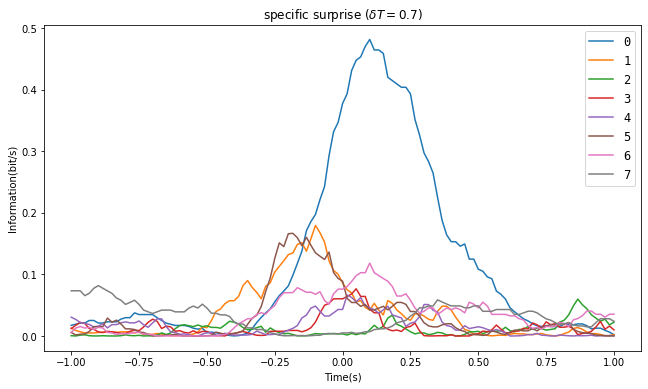

In [10]:
legend = []
for i in range(num_state):
    plt.plot(timeshift,MIxr_x1[i])
    legend.append(str(i))
plt.title('specific surprise '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

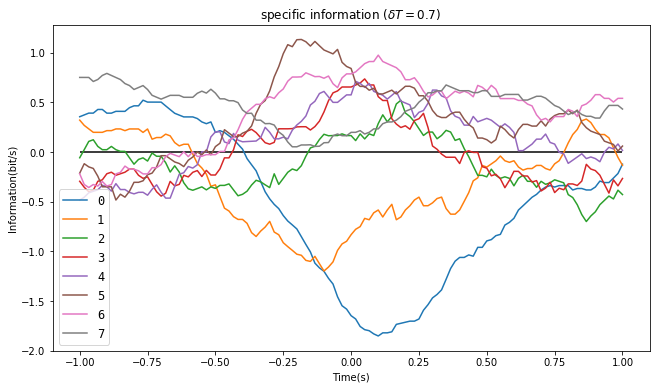

In [11]:
legend = []
# this denote change in uncertainty. I_s<0 means after knowing bar at somewhere, then  
for i in range(num_state):
    plt.plot(timeshift,MIxr_x2[i])
    legend.append(str(i))
plt.hlines(0, timeshift[0], timeshift[-1], 'k')
plt.title('specific information '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

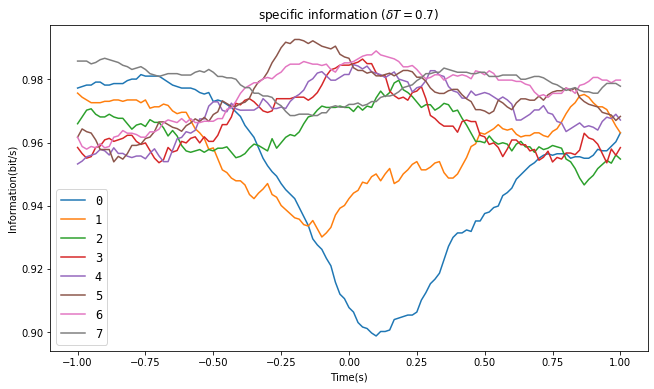

In [12]:
legend = []
# this denote change in uncertainty. I_s<0 means after knowing bar at somewhere, then  
for i in range(num_state):
    plt.plot(timeshift,np.squeeze(ppp[:,i]))
    legend.append(str(i))
plt.title('specific information '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

In [13]:
-np.nansum(pxr[0,0,:]*np.log2(pxr[0,0,:]))

0.39025239591498234

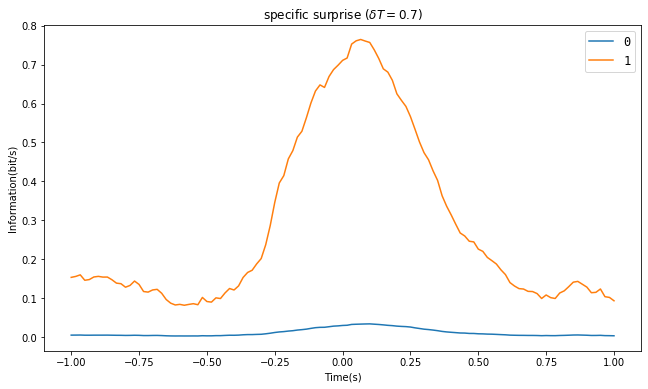

In [14]:
legend = []
for i in range(len(np.unique(rstate))):
    plt.plot(timeshift,MIxr_r1[i])
    legend.append(str(i))
plt.title('specific surprise '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

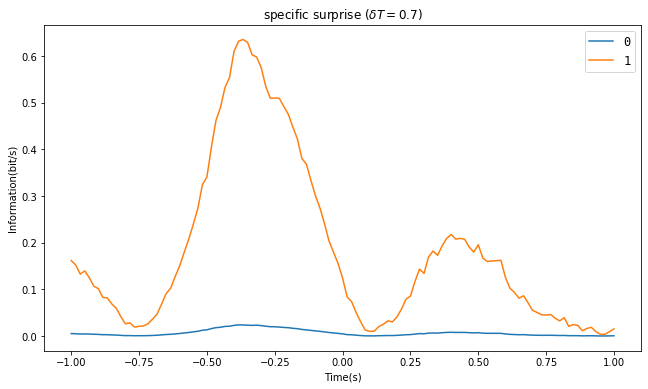

In [15]:
legend = []
for i in range(len(np.unique(rstate))):
    plt.plot(timeshift,MIvr_r1[i])
    legend.append(str(i))
plt.title('specific surprise '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

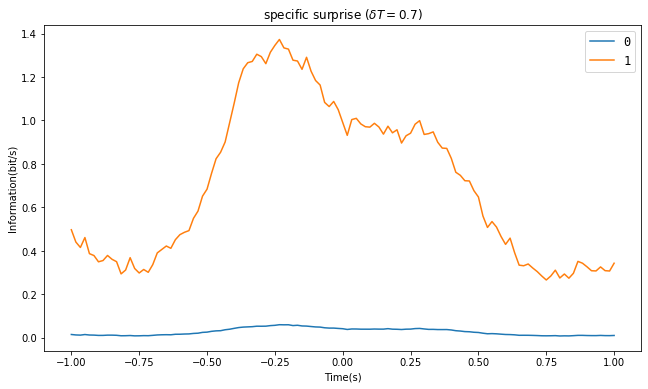

In [16]:
legend = []
for i in range(len(np.unique(rstate))):
    plt.plot(timeshift,MIxvR_r1[i])
    legend.append(str(i))
plt.title('specific surprise '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

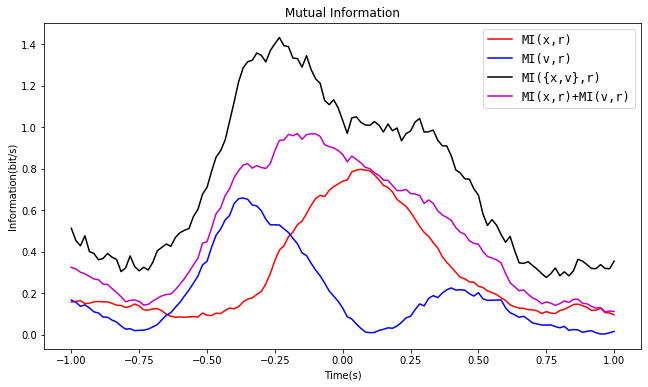

In [17]:
#plot MIs
plt.plot(timeshift,MIxr, 'r-')
plt.plot(timeshift,MIvr, 'b-')
plt.plot(timeshift,MIxvR, 'k-')
plt.plot(timeshift,MIxr+MIvr, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

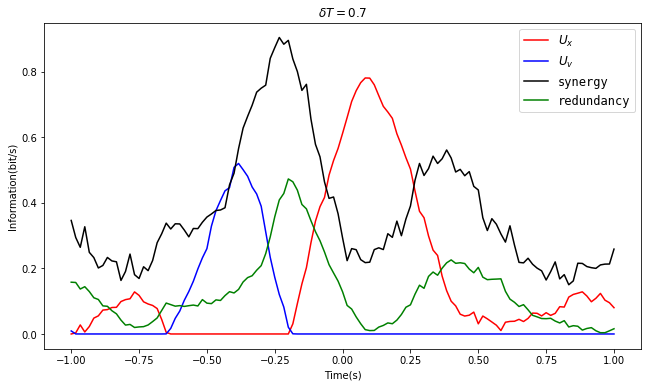

In [18]:
Ux = MIxr-Redun
Uv = MIvr-Redun
Syner = MIxvR-MIxr-MIvr+Redun
#plot PI
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title(r'$\delta T=$'+str(deltaT))
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

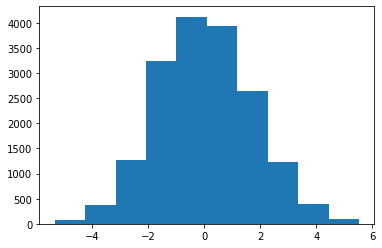

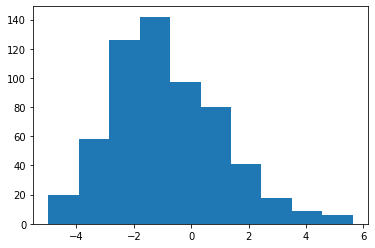

In [19]:
for n in np.unique(realr):
    fig, ax = plt.subplots()
    hst = ax.hist(r[np.where(realr == n)])